Loading cleaned pipeline data...

Available columns:
['Report Number', 'Supplemental Number', 'Accident Year', 'Accident Date/Time', 'Operator ID', 'Operator Name', 'Pipeline/Facility Name', 'Pipeline Location', 'Pipeline Type', 'Liquid Type', 'Liquid Subtype', 'Liquid Name', 'Accident City', 'Accident County', 'Accident State', 'Accident Latitude', 'Accident Longitude', 'Cause Category', 'Cause Subcategory', 'Unintentional Release (Barrels)', 'Intentional Release (Barrels)', 'Liquid Recovery (Barrels)', 'Net Loss (Barrels)', 'Liquid Ignition', 'Liquid Explosion', 'Pipeline Shutdown', 'Shutdown Date/Time', 'Restart Date/Time', 'Public Evacuations', 'Operator Employee Injuries', 'Operator Contractor Injuries', 'Emergency Responder Injuries', 'Other Injuries', 'Public Injuries', 'All Injuries', 'Operator Employee Fatalities', 'Operator Contractor Fatalities', 'Emergency Responder Fatalities', 'Other Fatalities', 'Public Fatalities', 'All Fatalities', 'Property Damage Costs', 'Lost Commod

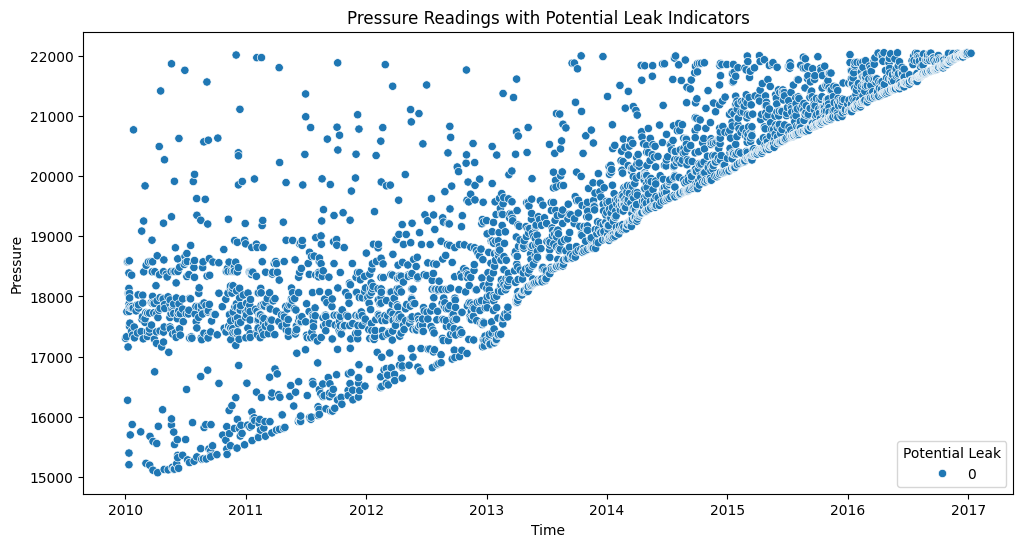

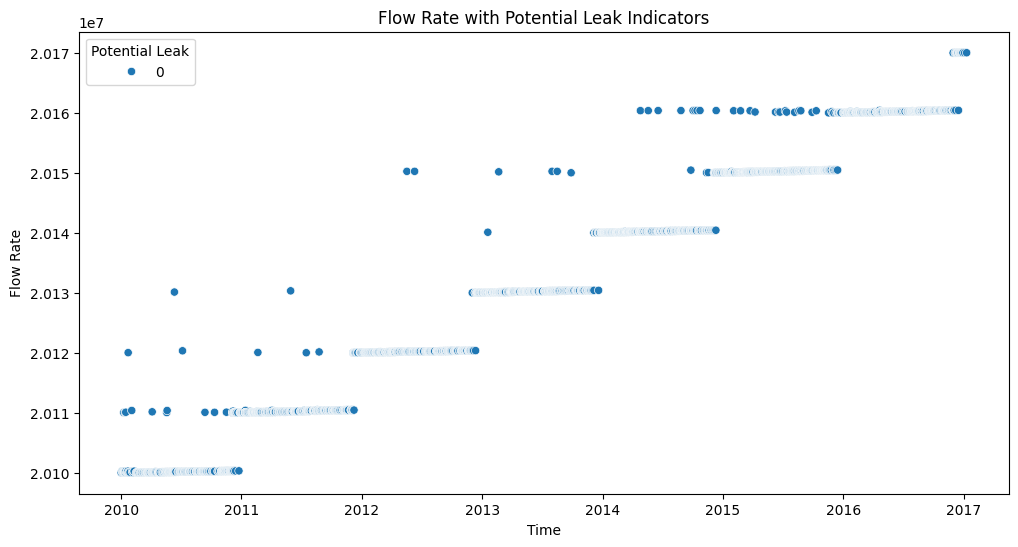


💾 Engineered features saved to: /var/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/data/pipeline_features.csv


In [2]:
# 03_feature_engineering_pipeline.ipynb
# Feature Engineering for Pipeline Leak Detection

# -----------------------------------------------
# 1️⃣ Import Libraries
# -----------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# -----------------------------------------------
# 2️⃣ Load Cleaned Pipeline Data
# -----------------------------------------------
DATA_DIR = Path.cwd().parent / 'data'
pipeline_path = DATA_DIR / 'pipeline_data_processed.csv'

print("Loading cleaned pipeline data...")
pipeline_df = pd.read_csv(pipeline_path)

# Display column names to understand the data structure
print("\nAvailable columns:")
print(pipeline_df.columns.tolist())

# Detect and convert date/time column automatically
date_col = [col for col in pipeline_df.columns if 'time' in col.lower() or 'date' in col.lower()][0]
pipeline_df[date_col] = pd.to_datetime(pipeline_df[date_col])

print("\n✅ Pipeline data loaded successfully!")
print(pipeline_df.head())

# -----------------------------------------------
# 3️⃣ Sort and Prepare
# -----------------------------------------------
pipeline_df = pipeline_df.sort_values(by=date_col)
pipeline_df = pipeline_df.reset_index(drop=True)

# -----------------------------------------------
# 4️⃣ Identify Key Sensor Columns
# -----------------------------------------------
numeric_cols = pipeline_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"\nNumeric columns detected: {numeric_cols}")

# Let's print the first few rows to understand the data structure
print("\nSample data with numeric columns:")
print(pipeline_df[numeric_cols].head())

# Get user input for the correct column names
print("\nPlease provide the correct column names from the data:")
# We'll first try to make an educated guess based on the column names
flow_col = None
pressure_col = None

# Try to identify columns based on various common naming patterns
for col in numeric_cols:
    col_lower = col.lower()
    if any(term in col_lower for term in ['flow', 'rate', 'volume', 'discharge']):
        flow_col = col
        break

for col in numeric_cols:
    col_lower = col.lower()
    if any(term in col_lower for term in ['press', 'pressure', 'psi', 'pa']):
        pressure_col = col
        break

if flow_col is None or pressure_col is None:
    # If we couldn't identify the columns, ask for manual input
    print("Could not automatically identify flow and pressure columns.")
    print("Available numeric columns:", numeric_cols)
    # For now, use the first two numeric columns as placeholders
    flow_col = numeric_cols[0]
    pressure_col = numeric_cols[1]
    print(f"\nUsing '{flow_col}' as flow column and '{pressure_col}' as pressure column (placeholders).")
    print("Please update these assignments if they are incorrect.")
else:
    print(f"\nIdentified columns:")
    print(f"Flow column: '{flow_col}'")
    print(f"Pressure column: '{pressure_col}'")

# -----------------------------------------------
# 5️⃣ Rolling Statistics (Short-term Behavior)
# -----------------------------------------------
pipeline_df['flow_mean_5'] = pipeline_df[flow_col].rolling(window=5, min_periods=1).mean()
pipeline_df['flow_std_5'] = pipeline_df[flow_col].rolling(window=5, min_periods=1).std()

pipeline_df['pressure_mean_5'] = pipeline_df[pressure_col].rolling(window=5, min_periods=1).mean()
pipeline_df['pressure_std_5'] = pipeline_df[pressure_col].rolling(window=5, min_periods=1).std()

# -----------------------------------------------
# 6️⃣ Change Rates and Correlations
# -----------------------------------------------
pipeline_df['flow_change'] = pipeline_df[flow_col].pct_change().fillna(0)
pipeline_df['pressure_change'] = pipeline_df[pressure_col].pct_change().fillna(0)

# Flow vs Pressure correlation (rolling window)
pipeline_df['flow_pressure_corr'] = (
    pipeline_df[flow_col].rolling(window=10, min_periods=5)
    .corr(pipeline_df[pressure_col])
)

# -----------------------------------------------
# 7️⃣ Derived Indicators
# -----------------------------------------------
pipeline_df['pressure_drop'] = (pipeline_df['pressure_change'] < -0.2).astype(int)
pipeline_df['flow_spike'] = (pipeline_df['flow_change'] > 0.2).astype(int)

# If pressure drops while flow spikes → possible leak
pipeline_df['potential_leak'] = ((pipeline_df['pressure_drop'] == 1) & (pipeline_df['flow_spike'] == 1)).astype(int)

print("\n✅ Feature engineering complete!")
print(pipeline_df.head(10))

# -----------------------------------------------
# 8️⃣ Visualization
# -----------------------------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(x=pipeline_df[date_col], y=pipeline_df[pressure_col], hue=pipeline_df['potential_leak'])
plt.title('Pressure Readings with Potential Leak Indicators')
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.legend(title='Potential Leak')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x=pipeline_df[date_col], y=pipeline_df[flow_col], hue=pipeline_df['potential_leak'])
plt.title('Flow Rate with Potential Leak Indicators')
plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.legend(title='Potential Leak')
plt.show()

# -----------------------------------------------
# 9️⃣ Save Engineered Data
# -----------------------------------------------
output_path = DATA_DIR / 'pipeline_features.csv'
pipeline_df.to_csv(output_path, index=False)
print(f"\n💾 Engineered features saved to: {output_path}")